In [21]:
import os
import numpy as np
import time
import tensorflow as tf
from tensorflow import keras

import matplotlib.pyplot as plt


np.random.seed(7128)
tf.random.set_seed(7128)

In [22]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

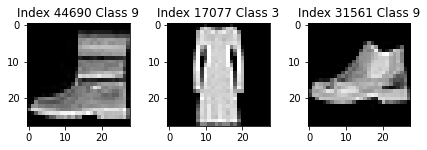

In [23]:
(X_train, y_train), (X_test, y_test) = keras.datasets.fashion_mnist.load_data() # Load MNIST or FMNIST
assert X_train.shape == (60000, 28, 28)
assert X_test.shape == (10000, 28, 28)
assert y_train.shape == (60000,)
assert y_test.shape == (10000,)


# Display randomly selected data
indices = list(np.random.randint(X_train.shape[0],size=3))
for i in range(3):
    plt.subplot(1,3,i+1)
    plt.imshow(X_train[indices[i]].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Index {} Class {}".format(indices[i], y_train[indices[i]]))
    plt.tight_layout()

In [24]:
# Split train dataset into train and validation
X_val = X_train[50000:60000]
X_train = X_train[0:50000]
y_val = y_train[50000:60000]
y_train = y_train[0:50000]

print("size of training set is", str(X_train.shape[0]), "samples")
print("every train example is", str(X_train.shape[1]), "by", str(X_train.shape[2]))

print("size of validation set is", str(X_val.shape[0]), "samples")
print("every validation example is", str(X_val.shape[1]), "by", str(X_val.shape[2]))

X_train = X_train.reshape(50000, 28*28)
X_val = X_val.reshape(10000, 28*28)
X_test = X_test.reshape(10000, 28*28)

print("size of training set is", str(X_train.shape[0]), "samples")
print("every train example has", str(X_train.shape[1]), "features")

print("size of validation set is", str(X_val.shape[0]), "samples")
print("every validation example has", str(X_val.shape[1]), "features")

# Split dataset into batches
#train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(16)
#test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(4)

size of training set is 50000 samples
every train example is 28 by 28
size of validation set is 10000 samples
every validation example is 28 by 28
size of training set is 50000 samples
every train example has 784 features
size of validation set is 10000 samples
every validation example has 784 features


In [25]:
#Normalize Data

X_train = X_train/255
X_val = X_val/255
X_test = X_test/255
# X_train[0]
np.max(X_train)

1.0

In [26]:
size_input = X_train.shape[1]
size_hidden1 = 128
size_hidden2 = 128
size_hidden3 = 128
size_output = 10

number_of_train_examples = X_train.shape[0]
number_of_test_examples = X_test.shape[0]

y_train = tf.keras.utils.to_categorical(y_train, num_classes=10) # Other function is tf.one_hot(y_train,depth=10)
y_val = tf.keras.utils.to_categorical(y_val, num_classes=10)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=10)
print(tf.shape(y_val))

tf.Tensor([10000    10], shape=(2,), dtype=int32)


# Importance of weight initialization

* One reason backprop based models can perform bettter lies with the weight initialization method, one important point one should remember is that, if yur weights are initialized to be too high or low, backprop would struggle.
* Hence one should always carefully initialize weights of your model, below i have shown approach with random_normal, one can use random_uniform, truncated version of both, Xavier init and orthogonal. 
* You will find modern day NNs have achieved stable and better performance by simply switching to better init and majority of cases Xavier or Orthogonal works best.
* Always initialize your bias using zero or some small constant (ideally 0.01 or less works better). We use bias to shift the activation and in some cases it can stabalize learning, but having large bias can cause negative results.

# Loss function

* We will always cross-entropy loss for classification.

* tf softmax,
loss= tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y_pred_tf, labels=y_true_tf)), this function is simply saying that it will calculate softmax for you, simply provide logits to it. 

* In other output of your forward pass directly goes this function. Now this operator will calculate or apply softmax over prediction or logits and calculate cross-entropy between prediction and target. I am using reduce_mean since we apply this over batches.
* Second is using keras
Method 1 :- This function requires logits, hence same as above you will pass logits or output variable to this function. Now remember you need from_logits = True, for this to work.
cce = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
loss_x = cce(y_true_tf, y_pred_tf) 

* Method 2:- In this we will apply softmax to output function and then pass to CCE loss.
So the approach is 
output = tf.nn.softmax(output)
cce = tf.keras.losses.CategoricalCrossentropy(from_logits=False)
loss_x = cce(y_true_tf, y_pred_tf) 

In [27]:
# Define class to build mlp model
class MLP_preact(object):
 def __init__(self, size_input, size_hidden1, size_hidden2, size_hidden3, size_output, device=None):
    """
    size_input: int, size of input layer
    size_hidden1: int, size of the 1st hidden layer
    size_hidden2: int, size of the 2nd hidden layer
    size_output: int, size of output layer
    device: str or None, either 'cpu' or 'gpu' or None. If None, the device to be used will be decided automatically during Eager Execution
    """
    self.size_input, self.size_hidden1, self.size_hidden2, self.size_hidden3, self.size_output, self.device =\
    size_input, size_hidden1, size_hidden2, size_hidden3, size_output, device
    
    # Initialize weights between input mapping and a layer g(f(x)) = layer
    self.W1 = tf.Variable(tf.random.normal([self.size_input, self.size_hidden1], stddev=0.1)) # Xavier(Fan-in fan-out) and Orthogonal
    # Initialize biases for hidden layer
    self.b1 = tf.Variable(tf.zeros([1, self.size_hidden1])) # 0 or constant(0.01)
    
    self.gamma1 = tf.Variable(tf.ones([1, self.size_hidden1]))
    self.beta1 = tf.Variable(tf.zeros([1, self.size_hidden1]))
    
    self.mu1 = tf.Variable(tf.ones([1, self.size_hidden1]))
    self.var1 = tf.Variable(tf.ones([1, self.size_hidden1]))
    
    # Initialize weights between input layer and 1st hidden layer
    self.W2 = tf.Variable(tf.random.normal([self.size_hidden1, self.size_hidden2], stddev=0.1))
    # Initialize biases for hidden layer
    self.b2 = tf.Variable(tf.zeros([1, self.size_hidden2]))
    
    self.gamma2 = tf.Variable(tf.ones([1, self.size_hidden2]))
    self.beta2 = tf.Variable(tf.zeros([1, self.size_hidden2]))
    
    self.mu2 = tf.Variable(tf.ones([1, self.size_hidden2]))
    self.var2 = tf.Variable(tf.ones([1, self.size_hidden2]))
    
    # Initialize weights between 1st hidden layer and 2nd hidden layer
    self.W3 = tf.Variable(tf.random.normal([self.size_hidden2, self.size_hidden3], stddev=0.1))
    # Initialize biases for hidden layer
    self.b3 = tf.Variable(tf.zeros([1, self.size_hidden3]))
    
    self.gamma3 = tf.Variable(tf.ones([1, self.size_hidden3]))
    self.beta3 = tf.Variable(tf.zeros([1, self.size_hidden3]))
    
    self.mu3 = tf.Variable(tf.ones([1, self.size_hidden3]))
    self.var3 = tf.Variable(tf.ones([1, self.size_hidden3]))
    
    # Initialize weights between 2nd hidden layer and output layer
    self.W4 = tf.Variable(tf.random.normal([self.size_hidden3, self.size_output], stddev=0.1))
    # Initialize biases for output layer
    self.b4 = tf.Variable(tf.zeros([1, self.size_output]))
    
    # Define variables to be updated during backpropagation
    self.eps = 0.001

    # Define variables to be updated during backpropagation
    self.variables = [self.W1, self.W2, self.W3, self.W4, self.b1, self.b2, self.b3, self.b4, self.gamma1, self.beta1, self.gamma2, self.beta2, self.gamma3, self.beta3 ]
  
 def forward(self, X, mode="test"):
    """
    forward pass
    X: Tensor, inputs
    """
    if self.device is not None:
      with tf.device('gpu:0' if self.device=='gpu' else 'cpu'):
        self.y = self.compute_output(X, mode)
    else:
      self.y = self.compute_output(X, mode)
      
    return self.y

 def batch_running_value(self, X):
    X_tf = tf.cast(X, dtype=tf.float32)
    z1 = tf.matmul(X_tf, self.W1) + self.b1
    self.mu1 = np.mean(z1, 0)
    self.var1 = tf.math.sqrt(np.var(z1, 0) - self.eps)
    zn1 = tf.nn.relu((self.gamma1 * (z1 - self.mu1) / self.var1) + self.beta1)

    z2 = tf.matmul(zn1, self.W2) + self.b2
    self.mu2 = np.mean(z2, 0)
    self.var2 = tf.math.sqrt(np.var(z2, 0) - self.eps)
    zn2 = tf.nn.relu((self.gamma2 * (z2 - self.mu2) / self.var2) + self.beta2)
    
    z3 = tf.matmul(zn2, self.W3) + self.b3
    self.mu3 = np.mean(z3, 0)
    self.var3 = tf.math.sqrt(np.var(z3, 0) - self.eps)
    zn3 = tf.nn.relu((self.gamma3 * (z3 - self.mu3) / self.var3 + self.beta3))

 def loss(self, y_pred, y_true):
    '''
    y_pred - Tensor of shape (batch_size, size_output)
    y_true - Tensor of shape (batch_size, size_output)
    '''
    #y_true_tf = tf.cast(tf.reshape(y_true, (-1, self.size_output)), dtype=tf.float32)
    y_true_tf = tf.cast(y_true, dtype=tf.float32)
    y_pred_tf = tf.cast(y_pred, dtype=tf.float32)
    cce = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
    loss_x = cce(y_true_tf, y_pred_tf)
    # Use keras or tf_softmax, both should work for any given model
    #loss_x = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y_pred_tf, labels=y_true_tf))
    
    return loss_x

 def backward(self, X_train, y_train, opti):
    """
    backward pass
    """
    optimizer = opti
    
    with tf.GradientTape() as tape:
        
      predicted = self.forward(X_train, 'train')
      current_loss = self.loss(predicted, y_train)
        
    grads = tape.gradient(current_loss, self.variables)
    optimizer.apply_gradients(zip(grads, self.variables))

    
 def compute_output(self, X, mode="test"):
    """
    Custom method to obtain output tensor during forward pass
    """
    # Cast X to float32
    X_tf = tf.cast(X, dtype=tf.float32)
    #X_tf = X

    if(mode == "test"):
      z1 = tf.matmul(X_tf, self.W1) + self.b1
      zn1 = tf.nn.relu((self.gamma1 * (z1 - self.mu1) / self.var1) + self.beta1)
    
      z2 = tf.matmul(zn1, self.W2) + self.b2
      zn2 = tf.nn.relu((self.gamma2 * (z2 - self.mu2) / self.var2) + self.beta2)
    
      z3 = tf.matmul(zn2, self.W3) + self.b3
      zn3 = tf.nn.relu((self.gamma3 * (z3 - self.mu3) / self.var3) + self.beta3)
 
      # Compute output
      output = tf.matmul(zn3, self.W4) + self.b4
      return (output)

    else:
      z1 = tf.matmul(X_tf, self.W1) + self.b1
      zn1 = tf.nn.relu((self.gamma1 * (z1 - np.mean(z1, 0)) / (tf.math.sqrt(np.var(z1, 0) - self.eps))) + self.beta1)
    
      z2 = tf.matmul(zn1, self.W2) + self.b2
      zn2 = tf.nn.relu((self.gamma2 * (z2 - np.mean(z2, 0)) / (tf.math.sqrt(np.var(z2, 0) - self.eps))) + self.beta2)
    
      z3 = tf.matmul(zn2, self.W3) + self.b3
      zn3 = tf.nn.relu((self.gamma3 * (z3 - np.mean(z3, 0)) / (tf.math.sqrt(np.var(z3, 0) - self.eps))) + self.beta3)
      # Compute output
      output = tf.matmul(zn3, self.W4) + self.b4
      return (output)


#  def stderr(self,y_pred):
#     """
#      Calculate standard error
#      """
#     y_pred_tf = tf.cast(y_pred, dtype=tf.float32)
#     std_dev = np.std(y_pred_tf) #Calculates standard deviation
#     std_err = std_dev/sqrt(len(y_pred_tf))
#     return std_err 


#  def var(self,y_pred):
#     """
#      Calculate variance 
#      """
#     y_pred_tf = tf.cast(y_pred, dtype=tf.float32)
#     std_dev = np.std(y_pred_tf) #Calculates standard deviation
#     variance = (std_dev**2) # calculate variance
#     return variance 




Train Accuracy: 0.6698
Number of Epoch = 1 - Average Cross Entropy:= 0.0077587335205078125 

Validation Accuracy: 0.6723

Train Accuracy: 0.7039
Number of Epoch = 2 - Average Cross Entropy:= 0.007146919555664062 

Validation Accuracy: 0.7027

Train Accuracy: 0.7522
Number of Epoch = 3 - Average Cross Entropy:= 0.006159100341796875 

Validation Accuracy: 0.7433

Train Accuracy: 0.7762
Number of Epoch = 4 - Average Cross Entropy:= 0.005335128173828125 

Validation Accuracy: 0.7657

Train Accuracy: 0.7874
Number of Epoch = 5 - Average Cross Entropy:= 0.004850011901855468 

Validation Accuracy: 0.7770

Train Accuracy: 0.8044
Number of Epoch = 6 - Average Cross Entropy:= 0.004508684997558594 

Validation Accuracy: 0.7931

Train Accuracy: 0.8145
Number of Epoch = 7 - Average Cross Entropy:= 0.004264195861816407 

Validation Accuracy: 0.8038

Train Accuracy: 0.8245
Number of Epoch = 8 - Average Cross Entropy:= 0.004056712646484375 

Validation Accuracy: 0.8140

Train Accuracy: 0.8268
Number 

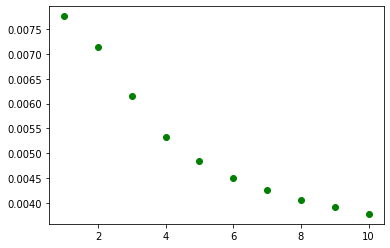

In [28]:
# Set number of epochs
NUM_EPOCHS = 10

# Initialize model using CPU
mpl_preact = MLP_preact(size_input, size_hidden1, size_hidden2, size_hidden3, size_output, device='gpu')

time_start = time.time()
opti = tf.keras.optimizers.SGD(learning_rate = 0.1)
for epoch in range(NUM_EPOCHS):
    
  loss_total = tf.zeros([1,1], dtype=tf.float32)
  lt = 0
    
  train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(25, seed=epoch*(7128)).batch(128)
  kz = 0
  accuracy_z = 0.0
  cur_train_acc = 0.0
  for inputs, outputs in train_ds:
    qw, tr = tf.shape(inputs)
    kz = kz + 1
    preds = mpl_preact.forward(inputs, 'train') 
    loss_total = loss_total + mpl_preact.loss(preds, outputs)
    lt = lt + mpl_preact.loss(preds, outputs)
    mpl_preact.backward(inputs, outputs, opti)
  mpl_preact.batch_running_value(X_train)
  preds = mpl_preact.forward(X_train, 'test')
  # Get probs, remember we only have logits from our forward function, we need to apply softmax on top of it to get probs
  preds = tf.nn.softmax(preds)
  correct_prediction = tf.equal(tf.argmax(preds, 1), tf.argmax(y_train, 1))
  accuracy_z = accuracy_z + tf.reduce_mean(tf.cast(correct_prediction, "float"))
  cur_train_acc += accuracy_z.numpy()
  ds = cur_train_acc
  print('\nTrain Accuracy: {:.4f}'.format(ds))
  print('Number of Epoch = {} - Average Cross Entropy:= {} '.format(epoch + 1, np.sum(loss_total) / X_train.shape[0]))
  preds_val = mpl_preact.forward(X_val, 'test')
  preds_val = tf.nn.softmax(preds_val)
  correct_prediction = tf.equal(tf.argmax(preds_val, 1), tf.argmax(y_val, 1))

  # Calculate accuracy
  accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
  cur_val_acc = accuracy.numpy()

  print('\nValidation Accuracy: {:.4f}'.format(cur_val_acc))
  
  plt.plot(epoch + 1, np.sum(loss_total) / X_train.shape[0], 'go')

        
time_taken = time.time() - time_start
    
# Validate model
    


print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))
#For per epoch_time = Total_Time / Number_of_epochs


In [29]:
# Define class to build mlp model
class MLP_postact(object):
 def __init__(self, size_input, size_hidden1, size_hidden2, size_hidden3, size_output, device=None):
    """
    size_input: int, size of input layer
    size_hidden1: int, size of the 1st hidden layer
    size_hidden2: int, size of the 2nd hidden layer
    size_output: int, size of output layer
    device: str or None, either 'cpu' or 'gpu' or None. If None, the device to be used will be decided automatically during Eager Execution
    """
    self.size_input, self.size_hidden1, self.size_hidden2, self.size_hidden3, self.size_output, self.device =\
    size_input, size_hidden1, size_hidden2, size_hidden3, size_output, device
    
    # Initialize weights between input mapping and a layer g(f(x)) = layer
    self.W1 = tf.Variable(tf.random.normal([self.size_input, self.size_hidden1], stddev=0.1)) # Xavier(Fan-in fan-out) and Orthogonal
    # Initialize biases for hidden layer
    self.b1 = tf.Variable(tf.zeros([1, self.size_hidden1])) # 0 or constant(0.01)
    
    self.gamma1 = tf.Variable(tf.ones([1, self.size_hidden1]))
    self.beta1 = tf.Variable(tf.zeros([1, self.size_hidden1]))
    
    self.mu1 = tf.Variable(tf.ones([1, self.size_hidden1]))
    self.var1 = tf.Variable(tf.ones([1, self.size_hidden1]))
    
    # Initialize weights between input layer and 1st hidden layer
    self.W2 = tf.Variable(tf.random.normal([self.size_hidden1, self.size_hidden2], stddev=0.1))
    # Initialize biases for hidden layer
    self.b2 = tf.Variable(tf.zeros([1, self.size_hidden2]))
    
    self.gamma2 = tf.Variable(tf.ones([1, self.size_hidden2]))
    self.beta2 = tf.Variable(tf.zeros([1, self.size_hidden2]))
    
    self.mu2 = tf.Variable(tf.ones([1, self.size_hidden2]))
    self.var2 = tf.Variable(tf.ones([1, self.size_hidden2]))
    
    # Initialize weights between 1st hidden layer and 2nd hidden layer
    self.W3 = tf.Variable(tf.random.normal([self.size_hidden2, self.size_hidden3], stddev=0.1))
    # Initialize biases for hidden layer
    self.b3 = tf.Variable(tf.zeros([1, self.size_hidden3]))
    
    self.gamma3 = tf.Variable(tf.ones([1, self.size_hidden3]))
    self.beta3 = tf.Variable(tf.zeros([1, self.size_hidden3]))
    
    self.mu3 = tf.Variable(tf.ones([1, self.size_hidden3]))
    self.var3 = tf.Variable(tf.ones([1, self.size_hidden3]))
    
    # Initialize weights between 2nd hidden layer and output layer
    self.W4 = tf.Variable(tf.random.normal([self.size_hidden3, self.size_output], stddev=0.1))
    # Initialize biases for output layer
    self.b4 = tf.Variable(tf.zeros([1, self.size_output]))
    
    # Define variables to be updated during backpropagation
    self.eps = 1e-8

    # Define variables to be updated during backpropagation
    self.variables = [self.W1, self.W2, self.W3, self.W4, self.b1, self.b2, self.b3, self.b4, self.gamma1, self.beta1, self.gamma2, self.beta2, self.gamma3, self.beta3]
  
 def forward(self, X, mode="test"):
    """
    forward pass
    X: Tensor, inputs
    """
    if self.device is not None:
      with tf.device('gpu:0' if self.device=='gpu' else 'cpu'):
        self.y = self.compute_output(X, mode)
    else:
      self.y = self.compute_output(X, mode)
      
    return self.y

 def batch_running_value(self, X):
    X_tf = tf.cast(X, dtype=tf.float32)
    z1 = tf.nn.relu(tf.matmul(X_tf, self.W1) + self.b1)
    self.mu1 = np.mean(z1, 0)
    self.var1 = tf.math.sqrt(np.var(z1, 0) - self.eps)
    zn1 = (self.gamma1 * (z1 - self.mu1) / self.var1) + self.beta1

    z2 = tf.nn.relu(tf.matmul(zn1, self.W2) + self.b2)
    self.mu2 = np.mean(z2, 0)
    self.var2 = tf.math.sqrt(np.var(z2, 0) - self.eps)
    zn2 = (self.gamma2 * (z2 - self.mu2) / self.var2) + self.beta2
    
    z3 = tf.nn.relu(tf.matmul(zn2, self.W3) + self.b3)
    self.mu3 = np.mean(z3, 0)
    self.var3 = tf.math.sqrt(np.var(z3, 0) - self.eps)
    #zn3 = (self.gamma3 * (z3 - self.mu3) / self.var3) + self.beta3

 def loss(self, y_pred, y_true):
    '''
    y_pred - Tensor of shape (batch_size, size_output)
    y_true - Tensor of shape (batch_size, size_output)
    '''
    #y_true_tf = tf.cast(tf.reshape(y_true, (-1, self.size_output)), dtype=tf.float32)
    y_true_tf = tf.cast(y_true, dtype=tf.float32)
    y_pred_tf = tf.cast(y_pred, dtype=tf.float32)
    cce = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
    loss_x = cce(y_true_tf, y_pred_tf)
    # Use keras or tf_softmax, both should work for any given model
    #loss_x = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y_pred_tf, labels=y_true_tf))
    
    return loss_x

 def backward(self, X_train, y_train, opti):
    """
    backward pass
    """
    optimizer = opti
    
    with tf.GradientTape() as tape:
        
      predicted = self.forward(X_train, 'train')
      current_loss = self.loss(predicted, y_train)
        
    grads = tape.gradient(current_loss, self.variables)
    optimizer.apply_gradients(zip(grads, self.variables))

    
 def compute_output(self, X, mode="test"):
    """
    Custom method to obtain output tensor during forward pass
    """
    # Cast X to float32
    X_tf = tf.cast(X, dtype=tf.float32)
    #X_tf = X

    if(mode == "test"):
      z1 = tf.nn.relu(tf.matmul(X_tf, self.W1) + self.b1)
      zn1 = (self.gamma1 * (z1 - self.mu1) / self.var1) + self.beta1
    
      z2 = tf.nn.relu(tf.matmul(zn1, self.W2) + self.b2)
      zn2 = (self.gamma2 * (z2 - self.mu2) / self.var2) + self.beta2
    
      z3 = tf.nn.relu(tf.matmul(zn2, self.W3) + self.b3)
      zn3 = (self.gamma3 * (z3 - self.mu3) / self.var3) + self.beta3
 
      # Compute output
      output = tf.matmul(zn3, self.W4) + self.b4
      return (output)

    else:
      z1 = tf.nn.relu(tf.matmul(X_tf, self.W1) + self.b1)
      zn1 = (self.gamma1 * (z1 - np.mean(z1, 0)) / (tf.math.sqrt(np.var(z1, 0) - self.eps))) + self.beta1
      
      z2_dummy = np.matmul(zn1, self.W2)
      z2 = tf.matmul(zn1, self.W2) + self.b2
      #print(z2_dummy, zn1, z2)
      #print(self.W2)
      #print(zn1)
      z2 = tf.nn.relu(z2)
      
      zn2 = (self.gamma2 * (z2 - np.mean(z2, 0)) / (tf.math.sqrt(np.var(z2, 0) - self.eps))) + self.beta2
      
      z3 = tf.nn.relu(tf.matmul(zn2, self.W3) + self.b3)
      zn3 = (self.gamma3 * (z3 - np.mean(z3, 0)) / (tf.math.sqrt(np.var(z3, 0) - self.eps))) + self.beta3
      
      # Compute output
      output = tf.matmul(zn3, self.W4) + self.b4
      return (output)


#  def stderr(self,y_pred):
#     """
#      Calculate standard error
#      """
#     y_pred_tf = tf.cast(y_pred, dtype=tf.float32)
#     std_dev = np.std(y_pred_tf) #Calculates standard deviation
#     std_err = std_dev/sqrt(len(y_pred_tf))
#     return std_err 


#  def var(self,y_pred):
#     """
#      Calculate variance 
#      """
#     y_pred_tf = tf.cast(y_pred, dtype=tf.float32)
#     std_dev = np.std(y_pred_tf) #Calculates standard deviation
#     variance = (std_dev**2) # calculate variance
#     return variance 


Train Accuracy: 0.0730
Number of Epoch = 1 - Average Cross Entropy:= 6.512537956237793e-05 

Validation Accuracy: 0.0830

Train Accuracy: 0.0829
Number of Epoch = 2 - Average Cross Entropy:= 6.23888635635376e-05 

Validation Accuracy: 0.0945

Train Accuracy: 0.0939
Number of Epoch = 3 - Average Cross Entropy:= 5.981029510498047e-05 

Validation Accuracy: 0.1050

Train Accuracy: 0.1057
Number of Epoch = 4 - Average Cross Entropy:= 5.738757610321045e-05 

Validation Accuracy: 0.1175

Train Accuracy: 0.1194
Number of Epoch = 5 - Average Cross Entropy:= 5.5114336013793945e-05 

Validation Accuracy: 0.1322

Train Accuracy: 0.1361
Number of Epoch = 6 - Average Cross Entropy:= 5.29808759689331e-05 

Validation Accuracy: 0.1473

Train Accuracy: 0.1553
Number of Epoch = 7 - Average Cross Entropy:= 5.09788179397583e-05 

Validation Accuracy: 0.1646

Train Accuracy: 0.1762
Number of Epoch = 8 - Average Cross Entropy:= 4.909986972808838e-05 

Validation Accuracy: 0.1859

Train Accuracy: 0.1988
Nu

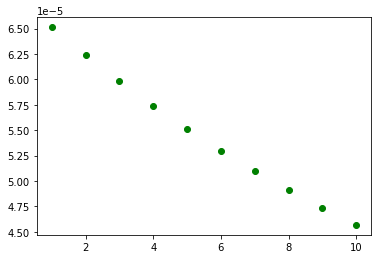

In [30]:
# Set number of epochs
NUM_EPOCHS = 10

# Initialize model using CPU
mpl_postact = MLP_postact(size_input, size_hidden1, size_hidden2, size_hidden3, size_output, device='gpu')

time_start = time.time()
opti = tf.keras.optimizers.SGD(learning_rate = 0.01)
for epoch in range(NUM_EPOCHS):
    
  loss_total = tf.zeros([1,1], dtype=tf.float32)
  lt = 0
    
  train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(25, seed=epoch*(7128)).batch(128)
  accuracy_z = 0.0
  cur_train_acc = 0.0
  
  preds = mpl_postact.forward(X_train, 'train') 
  loss_total = loss_total + mpl_postact.loss(preds, y_train)
  lt = lt + mpl_postact.loss(preds, y_train)
  mpl_postact.backward(X_train, y_train, opti)
  mpl_postact.batch_running_value(X_train)
  preds = mpl_postact.forward(X_train, 'test')
  # Get probs, remember we only have logits from our forward function, we need to apply softmax on top of it to get probs
  preds = tf.nn.softmax(preds)
  correct_prediction = tf.equal(tf.argmax(preds, 1), tf.argmax(y_train, 1))
  accuracy_z = accuracy_z + tf.reduce_mean(tf.cast(correct_prediction, "float"))
  cur_train_acc += accuracy_z.numpy()
  ds = cur_train_acc
  print('\nTrain Accuracy: {:.4f}'.format(ds))
  print('Number of Epoch = {} - Average Cross Entropy:= {} '.format(epoch + 1, np.sum(loss_total) / X_train.shape[0]))
  preds_val = mpl_postact.forward(X_val, 'test')
  preds_val = tf.nn.softmax(preds_val)
  correct_prediction = tf.equal(tf.argmax(preds_val, 1), tf.argmax(y_val, 1))

  # Calculate accuracy
  accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
  cur_val_acc = accuracy.numpy()

  print('\nValidation Accuracy: {:.4f}'.format(cur_val_acc))
  
  plt.plot(epoch + 1, np.sum(loss_total) / X_train.shape[0], 'go')

        
time_taken = time.time() - time_start
    
# Validate model
    


print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))
#For per epoch_time = Total_Time / Number_of_epochs
